<a href="https://colab.research.google.com/github/npuneeth/York_Univ_NLP/blob/main/Milestone_2_Benchmarking_and_Interpreting_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Group Project: Disaster Tweet Prediction** 
## *Milestone 2: Benchmarking and Interpreting Features* 
**CSML-1010 | By GROUP 3 & 4** (*Jean-Jacques Rousseau, David Geller, Kwangjin Park, Petr Kocourek and Puneeth Nagarajaiah, Imdad Khan*)

### Goal: We are going  perform feature extraction on our dataset and measure performance bench mark models.

## **Table of Content:**

1.   Installation
2.   Additional Data Cleaning & Creating new Dataframes
3.   Creating a list of tokens/words from Tweets
4.   Creating Word2Vec model: Method 1 (Based on Week 1 Coding Exercise)
5.   Bag-of-Words Model
6.   Bag-of-2Grams Model
7.   TF-IDF Model
8.   Topic Model
9.   Classification modelling using Pycaret
10.  Creating Word2Vec model: Method 2 (Using gensim and beautifulsoup4)
11.  Building classification models based on dataset created in Part 4 (Creating Word2Vec model: Method 1) 
12. BERT 
13. Conclusion





##1. Installation

In [ ]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

In [ ]:
#for panda profiling and plotting
! pip install pandas
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
pd.options.display.max_colwidth = 200

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Processed training data from Milestone 1
train_data = pd.read_csv('/content/drive/MyDrive/train_data_processed.csv')

In [ ]:
train_data.head()

,Unnamed: 0,keyword,text,target,text_clean,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
0,0,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,our deed be the reason of this earthquake may ALLAH forgive we all,deed reason earthquake ALLAH,NaN,forgive,deed reason earthquake ALLAH forgive,13.0
1,1,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near La Ronge Sask . Canada,forest fire La Ronge Sask Canada,NaN,NaN,forest fire La Ronge Sask Canada,8.0
2,2,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all resident ask to ' shelter in place ' be be notify by officer . no other evacuation or shelter in place order be expect,resident shelter place officer evacuation shelter place order,other,ask notify expect,resident shelter place officer evacuation shelter place order other ask notify expect,25.0
3,3,NaN,"13,000 people receive #wildfires evacuation orders in California",1,", people receive wildfires evacuation orders in California",", people receive wildfire evacuation order in California",people evacuation order California,NaN,receive wildfire,people evacuation order California receive wildfire,10.0
4,4,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,just got send this photo from Ruby Alaska as smoke from wildfire pour into a school,photo Ruby Alaska smoke wildfire pour school,NaN,send,photo Ruby Alaska smoke wildfire pour school send,16.0


In [ ]:
#Original data from Kaggle website
train_data_orig=pd.read_csv('/content/drive/MyDrive/train_original.csv')

In [ ]:
#Pre-processed data to be used for comparision in terems of performance
train_data_orig.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## 2. Additional Data Cleaning

In [ ]:
#Creating new Dataframe from pre-processed dataset
corpus = []
labels = []
keywords = []

for i, row in train_data.iterrows():
  corpus.append(row.text_clean)

for i, row in train_data.iterrows():
  labels.append(row.target)

for i, row in train_data.iterrows():
  keywords.append(row.keyword)

In [ ]:
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Keyword': keywords, 'Document': corpus, 'Target': labels})
corpus_df = corpus_df[['Keyword','Document', 'Target']]

#New Dataframe
corpus_df

,Keyword,Document,Target
0,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,NaN,", people receive wildfires evacuation orders in California",1
4,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1
...,...,...,...
7608,NaN,Two giant cranes holding a bridge collapse into nearby homes,1
7609,NaN,The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,NaN,M . UTC km S of Volcano Hawaii.,1
7611,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [ ]:
#Just showing tweets
corpus

array(['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'M .     UTC  km S of Volcano Hawaii. ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest More Homes Razed by Northern California Wildfire ABC News '],
      dtype='<U146')

Let's perform additional data cleaning.

In [ ]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z \s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_corpus = normalize_corpus(corpus)

#Data cleaned tweets
norm_corpus

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'utc km volcano hawaii',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
       'latest homes razed northern california wildfire abc news'],
      dtype='<U138')

In [ ]:
corpus_df = pd.DataFrame({'Keyword': keywords, 'Document': norm_corpus, 'Target': labels})
corpus_df = corpus_df[['Keyword','Document', 'Target']]

#New Dataframe with Data cleaned tweets
corpus_df

,Keyword,Document,Target
0,NaN,deeds reason earthquake may allah forgive us,1
1,NaN,forest fire near la ronge sask canada,1
2,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,NaN,people receive wildfires evacuation orders california,1
4,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...
7608,NaN,two giant cranes holding bridge collapse nearby homes,1
7609,NaN,control wild fires california even northern part state troubling,1
7610,NaN,utc km volcano hawaii,1
7611,NaN,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries,1


In [ ]:
#Going to create a second set of corpus for removing duplicate letters
cp2_corpus = norm_corpus
cp2_corpus

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'utc km volcano hawaii',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
       'latest homes razed northern california wildfire abc news'],
      dtype='<U138')

Perform another round of data cleaning to get rid of duplicate letters.

In [ ]:
import re
wpt = nltk.WordPunctTokenizer()

#This function is used for getting rid of repeated words like 'aaaaaaalllll' or 'aaannnnnnd'
def remove_repeat_document(doc):
    repeat_pattern = re.compile(r'(\w)\1*')
    match_substitution = r'\1'
    # tokenize document
    tokens = wpt.tokenize(doc)
    filtered_tokens = []
    # filter stopwords out of document
    for token in tokens:
      filtered_tokens.append(repeat_pattern.sub(match_substitution, token))
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

remove_repeat_letters = np.vectorize(remove_repeat_document)

In [ ]:
filtered_corpus = remove_repeat_letters(cp2_corpus)

In [ ]:
import numpy as np

#Going to create a sample of filtered corpus for plotting (since plotting 7000 words will not be viable)
filtered_corpus_sampled = np.random.choice(filtered_corpus, 50)
filtered_corpus_sampled.size

50

In [ ]:
corpus_df = pd.DataFrame({'Keyword': keywords, 'Document': filtered_corpus, 'Target': labels})
corpus_df = corpus_df[['Keyword','Document', 'Target']]

#Final Dataframe with cleaned up tweet
corpus_df

,Keyword,Document,Target
0,NaN,deds reason earthquake may alah forgive us,1
1,NaN,forest fire near la ronge sask canada,1
2,NaN,residents asked shelter place notified oficers evacuation shelter place orders expected,1
3,NaN,people receive wildfires evacuation orders california,1
4,NaN,got sent photo ruby alaska smoke wildfires pours schol,1
...,...,...,...
7608,NaN,two giant cranes holding bridge colapse nearby homes,1
7609,NaN,control wild fires california even northern part state troubling,1
7610,NaN,utc km volcano hawai,1
7611,NaN,police investigating ebike colided car litle portugal ebike rider sufered serious nonlife threatening injuries,1


#3. Creating a list of words/tokens from Tweets

In [ ]:
all_words = [nltk.word_tokenize(sent) for sent in filtered_corpus]

In [ ]:
for words in all_words:
  print(words)

Streaming output truncated to the last 5000 lines.
['help', 'save', 'beautiful', 'town', 'ontario', 'destruction', 'power', 'plant', 'developer']
['crackdown', 'destruction', 'restricted', 'multiplayer', 'crackdown', 'impresed', 'earlier', 'wek', 'demonstratio']
['gred', 'fuel', 'selfdestruction', 'takecare']
['contrasts', 'foreboding', 'destruction', 'enhanced', 'expansive', 'divisions', 'color', 'saturation', 'contrast', 'hue']
['rusian', 'authorities', 'take', 'acount', 'petition', 'destruction', 'sanctioned', 'fod', 'vladimir', 'putins', 'pres']
['fal', 'back', 'first', 'break', 'homebuyer', 'miscalculation', 'could', 'destruction', 'thousands', 'mwjcdk']
['theres', 'fly', 'lose', 'workspace', 'two', 'bored', 'cats', 'forse', 'terible', 'things', 'destruction', 'badkity', 'thisiswhywecanthavenicethings']
['many', 'specs', 'much', 'fan', 'service', 'much', 'lore', 'destruction']
['truck', 'driver', 'salvages', 'baned', 'tomatoes', 'destruction', 'rusian', 'border', 'news']
['republi

In [ ]:
#We need to get rid of '[' and ']'
all_words

[['deds', 'reason', 'earthquake', 'may', 'alah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'oficers',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'schol'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flod',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'floding',
  'strets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hil', 'se', 'fire', 'wods'],
 ['theres',
  'emergency',
  'evacuation',
  'hapening',
  'building',
  'acros',
  'stret'],
 ['im', 'afraid', 'tornado', 'coming', 'area'],
 ['thre', 'people', 'died', 'heat', 'wave', 'far'],
 ['haha',
  'south

In [ ]:
def clean(s):
  s = s.replace(r'[', "")
  s = s.replace(r']', "")

In [ ]:
#create one big list of words
concat_list = [j for i in all_words for j in i]

In [ ]:
#we can use this list to create other models, such as Word2Vec
concat_list

['deds',
 'reason',
 'earthquake',
 'may',
 'alah',
 'forgive',
 'us',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'residents',
 'asked',
 'shelter',
 'place',
 'notified',
 'oficers',
 'evacuation',
 'shelter',
 'place',
 'orders',
 'expected',
 'people',
 'receive',
 'wildfires',
 'evacuation',
 'orders',
 'california',
 'got',
 'sent',
 'photo',
 'ruby',
 'alaska',
 'smoke',
 'wildfires',
 'pours',
 'schol',
 'rockyfire',
 'update',
 'california',
 'hwy',
 'closed',
 'directions',
 'due',
 'lake',
 'county',
 'fire',
 'cafire',
 'wildfires',
 'flod',
 'disaster',
 'heavy',
 'rain',
 'causes',
 'flash',
 'floding',
 'strets',
 'manitou',
 'colorado',
 'springs',
 'areas',
 'im',
 'top',
 'hil',
 'se',
 'fire',
 'wods',
 'theres',
 'emergency',
 'evacuation',
 'hapening',
 'building',
 'acros',
 'stret',
 'im',
 'afraid',
 'tornado',
 'coming',
 'area',
 'thre',
 'people',
 'died',
 'heat',
 'wave',
 'far',
 'haha',
 'south',
 'ta',
 'geting',
 'floded',
 'wait'

#4. Creating Word2Vec model: Method 1 (Based on Week 1 Coding Exercise)




In [ ]:
#create Word2vec model

#clean_text_tok contains tokenized tweet
corpus_df['clean_text_tok']=[nltk.word_tokenize(i) for i in corpus_df['Document']] #convert preprocessed sentence to tokenized sentence

#min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it
model = Word2Vec(corpus_df['clean_text_tok'],min_count=2)  

#combination of word and its vector
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

<ipython-input-27-8ff3941a5700>:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  w2v = dict(zip(model.wv.index2word, model.wv.syn0))


### Train test splitting of labelled dataset (To be used later when creating classification models)



In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(corpus_df["Document"],
                                                  corpus_df["Target"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

#5. Bag of Words Models

### Comparison 1: Using a corpus that contains duplicate letters

In [ ]:
#Bag of Words Model on Corpus without removing duplicate letters
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aal,aan,aannnnd,aar,aashiqui,...,zones,zonewolf,zoom,zotar,zouma,zrnf,zss,zumiez,zurich,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Comparison 2: Using a corpus without duplicate letters

In [ ]:
#Bag of Words Model on Corpus after removing duplicate letters
cv2 = CountVectorizer(min_df=0., max_df=1.)
cv_matrix2 = cv2.fit_transform(filtered_corpus)
cv_matrix2 = cv_matrix2.toarray()
cv_matrix2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# get all unique words in the corpus
vocab2 = cv2.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix2, columns=vocab2)

,ab,aba,abandon,abandoned,abandoning,abc,abcnews,abcs,abe,aberden,...,zombies,zone,zones,zonewolf,zotar,zouma,zrnf,zs,zumiez,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#6. Bag of 2-Grams Model

### Comparison 1: Using a corpus that contains duplicate letters

In [ ]:
# Bag of 2-Grams Model on Corpus without filtering duplicate letters
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
pd.DataFrame(bv_matrix, columns=vocab)

,aa ayyo,aa batteries,aa mgm,aaaa ok,aaaaaaallll even,aaaaaand theres,aan den,aannnnd reddit,aar ambulancewe,aashiqui actress,...,zones cut,zones thank,zonewolf liked,zoom ones,zotar skeleton,zouma absolutely,zouma flattened,zss vs,zumiez location,zurich swiss
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Comparison 2: Using a corpus without duplicate letters

In [ ]:
# Bag of 2-Grams Model on Corpus after filtering duplicate letters
bv2 = CountVectorizer(ngram_range=(2,2))
bv_matrix2 = bv2.fit_transform(filtered_corpus)

bv_matrix2 = bv_matrix2.toarray()
vocab2 = bv2.get_feature_names_out()
pd.DataFrame(bv_matrix2, columns=vocab2)

,ab resin,aba woman,abandon plans,abandon ship,abandon west,abandoned aircraft,abandoned cabin,abandoned cocker,abandoned lrt,abandoned sinking,...,zone war,zones cut,zones thank,zonewolf liked,zotar skeleton,zouma absolutely,zouma flatened,zs vs,zumiez location,zurich swis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#7. TF-IDF Model

### Comparison 1: Using a corpus that contains duplicate letters

In [ ]:
# TF-IDF Model on Corpus before filtering duplicate letters
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aal,aan,aannnnd,aar,aashiqui,...,zones,zonewolf,zoom,zotar,zouma,zrnf,zss,zumiez,zurich,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Document Similarity using first corpus
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

### Comparison 2: Using a corpus without duplicate letters

In [ ]:
# TF-IDF Model on Corpus after filtering duplicate letters
tv2 = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix2 = tv2.fit_transform(filtered_corpus)
tv_matrix2 = tv_matrix2.toarray()

vocab2 = tv2.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix2, 2), columns=vocab2)

,ab,aba,abandon,abandoned,abandoning,abc,abcnews,abcs,abe,aberden,...,zombies,zone,zones,zonewolf,zotar,zouma,zrnf,zs,zumiez,zurich
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Document Similarity using second corpus
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix2 = cosine_similarity(tv_matrix2)
similarity_df2 = pd.DataFrame(similarity_matrix2)
similarity_df2

In [ ]:
# SAMPLED TF-IDF Model on Corpus after filtering duplicate letters FOR PLOTTING

tv3 = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix3 = tv3.fit_transform(filtered_corpus_sampled)
tv_matrix3 = tv_matrix3.toarray()

vocab3 = tv3.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix3, 2), columns=vocab3)

,aba,able,abortion,ace,acount,adelaide,afected,age,agre,alt,...,world,wory,would,wounds,wrong,yeah,yes,yet,yr,zhejiang
0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
1,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.66,0.00,0.0,0.0,0.0,0.00,0.00,0.00
2,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.3,0.0,0.3,0.00,0.00,0.00
3,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
4,0.36,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
5,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
6,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
7,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
8,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.27,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
9,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00


In [ ]:
# Document Similarity using second corpus
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix3 = cosine_similarity(tv_matrix3)
similarity_df3 = pd.DataFrame(similarity_matrix3)
similarity_df3

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.168840,0.0
8,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Clustering documents using similarity features

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

#plot based on second corpus
Z = linkage(similarity_matrix3, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2','Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,17.0,27.0,0.408717,2.0
1,22.0,26.0,0.872993,2.0
2,10.0,44.0,1.125331,2.0
3,0.0,16.0,1.145709,2.0
4,7.0,48.0,1.190748,2.0
5,9.0,35.0,1.245405,2.0
6,29.0,36.0,1.246806,2.0
7,30.0,40.0,1.251091,2.0
8,6.0,18.0,1.253699,2.0
9,19.0,25.0,1.269662,2.0


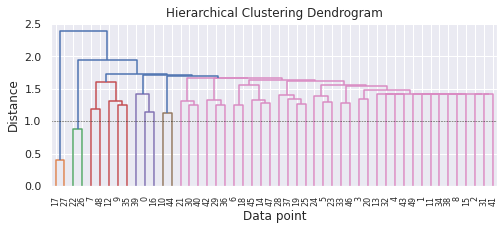

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Keyword,Document,Target,clean_text_tok,ClusterLabel
0,NaN,deds reason earthquake may alah forgive us,1,"[deds, reason, earthquake, may, alah, forgive, us]",8.0
1,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",44.0
2,NaN,residents asked shelter place notified oficers evacuation shelter place orders expected,1,"[residents, asked, shelter, place, notified, oficers, evacuation, shelter, place, orders, expected]",47.0
3,NaN,people receive wildfires evacuation orders california,1,"[people, receive, wildfires, evacuation, orders, california]",33.0
4,NaN,got sent photo ruby alaska smoke wildfires pours schol,1,"[got, sent, photo, ruby, alaska, smoke, wildfires, pours, schol]",35.0
...,...,...,...,...,...
7608,NaN,two giant cranes holding bridge colapse nearby homes,1,"[two, giant, cranes, holding, bridge, colapse, nearby, homes]",NaN
7609,NaN,control wild fires california even northern part state troubling,1,"[control, wild, fires, california, even, northern, part, state, troubling]",NaN
7610,NaN,utc km volcano hawai,1,"[utc, km, volcano, hawai]",NaN
7611,NaN,police investigating ebike colided car litle portugal ebike rider sufered serious nonlife threatening injuries,1,"[police, investigating, ebike, colided, car, litle, portugal, ebike, rider, sufered, serious, nonlife, threatening, injuries]",NaN


#8. Topic Models

### Create LDA model based on second corpus


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation( max_iter=1000, random_state=0)
dt_matrix = lda.fit_transform(tv_matrix3)
features = pd.DataFrame(dt_matrix)
features

,0,1,2,3,4,5,6,7,8,9
0,0.026243,0.026240,0.026239,0.026242,0.026239,0.026239,0.026244,0.763835,0.026239,0.026240
1,0.036838,0.036834,0.036833,0.668493,0.036833,0.036833,0.036833,0.036834,0.036833,0.036834
2,0.026928,0.026928,0.026928,0.026928,0.026928,0.757648,0.026928,0.026928,0.026928,0.026928
3,0.782791,0.024134,0.024134,0.024135,0.024134,0.024134,0.024134,0.024134,0.024134,0.024134
4,0.026130,0.026130,0.026130,0.026130,0.026130,0.764827,0.026130,0.026130,0.026131,0.026130
5,0.024033,0.024033,0.024033,0.024033,0.024033,0.024033,0.024033,0.783703,0.024033,0.024033
6,0.030950,0.030950,0.721444,0.030950,0.030950,0.030951,0.030952,0.030950,0.030950,0.030950
7,0.774817,0.025020,0.025020,0.025020,0.025020,0.025020,0.025020,0.025020,0.025021,0.025020
8,0.021096,0.810146,0.021095,0.021095,0.021095,0.021095,0.021095,0.021095,0.021095,0.021095
9,0.026138,0.026138,0.026138,0.026138,0.026138,0.026139,0.026138,0.026138,0.026138,0.764759


### Show topics and their weights

In [ ]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab3, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('electrocuted', 0.9505973578752088), ('curfew', 0.8071067674658902), ('fact', 0.8071067674658902), ('cables', 0.7817262238894391), ('death', 0.7817262238894391), ('elephant', 0.7817262238894391), ('literaly', 0.7817262238894391), ('metal', 0.7817262238894391), ('theres', 0.7817262238894391), ('tied', 0.7817262238894391), ('video', 0.7305763701092975)]

[('lights', 0.6773502613502981), ('people', 0.6761050985004641)]

[]

[('childhod', 0.807106775329395), ('efects', 0.807106775329395), ('estemed', 0.807106775329395), ('journalist', 0.807106775329395), ('recals', 0.807106775329395), ('tragic', 0.807106775329395), ('trauma', 0.807106775329395), ('unadresed', 0.807106775329395), ('would', 0.7573719144597667), ('inundated', 0.6944972184618984), ('seismic', 0.6298119845095985), ('dont', 0.6011481002565395)]

[]

[('great', 0.7030226820935538)]

[('us', 0.7062089423228554)]

[('think', 0.9165111532093325), ('anything', 0.6931639004087283), ('families', 0.6547001862601249), ('legionaires', 0

### Clustering documents using topic model features

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Keyword,Document,Target,clean_text_tok,ClusterLabel
0,NaN,deds reason earthquake may alah forgive us,1,"[deds, reason, earthquake, may, alah, forgive, us]",0.0
1,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",1.0
2,NaN,residents asked shelter place notified oficers evacuation shelter place orders expected,1,"[residents, asked, shelter, place, notified, oficers, evacuation, shelter, place, orders, expected]",1.0
3,NaN,people receive wildfires evacuation orders california,1,"[people, receive, wildfires, evacuation, orders, california]",1.0
4,NaN,got sent photo ruby alaska smoke wildfires pours schol,1,"[got, sent, photo, ruby, alaska, smoke, wildfires, pours, schol]",1.0
...,...,...,...,...,...
7608,NaN,two giant cranes holding bridge colapse nearby homes,1,"[two, giant, cranes, holding, bridge, colapse, nearby, homes]",NaN
7609,NaN,control wild fires california even northern part state troubling,1,"[control, wild, fires, california, even, northern, part, state, troubling]",NaN
7610,NaN,utc km volcano hawai,1,"[utc, km, volcano, hawai]",NaN
7611,NaN,police investigating ebike colided car litle portugal ebike rider sufered serious nonlife threatening injuries,1,"[police, investigating, ebike, colided, car, litle, portugal, ebike, rider, sufered, serious, nonlife, threatening, injuries]",NaN


#9. Classification modelling using Pycaret

In [ ]:
!pip install numpy
!pip install pycaret==2.3.5

In [ ]:
! pip install pandas
import pandas as pd
import pandas_profiling as pp 

### CREATE NAIVE BAYES MODEL USING UNPROCESSED DATASET

In [ ]:
train_data.shape

In [ ]:
profile = pp.ProfileReport(train_data) 
profile.to_file("output.html")
profile

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

In [ ]:
from pycaret.classification import * 

In [ ]:
exp_clf101 = setup(data = train_data, target = 'target', session_id=123,) 

In [ ]:
best_model = compare_models(fold=5)
print(best_model)

In [ ]:
nb = create_model('nb', fold=3)

In [ ]:
tuned_nb = tune_model(nb, fold=3)

In [ ]:
plot_model(tuned_nb, plot = 'auc')

In [ ]:
plot_model(tuned_nb, plot ='pr')

In [ ]:
plot_model(tuned_nb, plot ='confusion_matrix')

#10. Creating Word2Vec model: Method 2 (Using gensim and beautifulsoup4)

In [ ]:
pip install beautifulsoup4

In [ ]:
pip install lxml

In [ ]:
import bs4 as bs
import re
import nltk

In [ ]:
from gensim.models import Word2Vec

In [ ]:
#The only parameter that we need to specify is ‘min_count’. 
#When ‘min_count’ is 2, the processor includes only those words for vector representation that occur in the dataset at least 2 times. 
word2vec = Word2Vec(all_words, min_count=2)

In [ ]:
vocabulary = word2vec.wv.vocab

In [ ]:
print(vocabulary)

{'deds': <gensim.models.keyedvectors.Vocab object at 0x7f41877d4070>, 'reason': <gensim.models.keyedvectors.Vocab object at 0x7f41819940d0>, 'earthquake': <gensim.models.keyedvectors.Vocab object at 0x7f41819946a0>, 'may': <gensim.models.keyedvectors.Vocab object at 0x7f41879e7880>, 'alah': <gensim.models.keyedvectors.Vocab object at 0x7f41814dcfa0>, 'forgive': <gensim.models.keyedvectors.Vocab object at 0x7f41814dc2b0>, 'us': <gensim.models.keyedvectors.Vocab object at 0x7f4186f01070>, 'forest': <gensim.models.keyedvectors.Vocab object at 0x7f4186f01df0>, 'fire': <gensim.models.keyedvectors.Vocab object at 0x7f4186f013d0>, 'near': <gensim.models.keyedvectors.Vocab object at 0x7f4186f018b0>, 'la': <gensim.models.keyedvectors.Vocab object at 0x7f4186f01340>, 'canada': <gensim.models.keyedvectors.Vocab object at 0x7f4186f01670>, 'residents': <gensim.models.keyedvectors.Vocab object at 0x7f4186f014f0>, 'asked': <gensim.models.keyedvectors.Vocab object at 0x7f4186f01d30>, 'shelter': <gensi

The primary purpose of creating this model is to represent words in a multi-dimensional space.

When ‘v1’ is printed using the following code, we get the vector representation of the word ‘disaster’ based on the semantics.

The default number of dimensions in a vector created by the Gensim Word2vec model is a hundred. Thus, the vector representation of the word ‘disaster’ looks like the following.

In [ ]:
v1 = word2vec.wv['disaster']
print(v1)

[-0.03707289  0.07191474 -0.13208415 -0.1736374   0.22714236 -0.19274378
  0.13170286 -0.28435144  0.15679832  0.0839186   0.31420884 -0.00842134
  0.22748977 -0.07715348 -0.01212196  0.08374482  0.2742444   0.03108985
 -0.00106348 -0.3509097  -0.0233001   0.0577431  -0.08996436  0.16969678
 -0.03953322 -0.33017856 -0.28568017 -0.271897    0.2253586  -0.00283672
 -0.03890383 -0.24766816  0.00584613  0.10813327  0.10594451  0.06414602
 -0.3364215   0.09167945  0.10665732 -0.14265811 -0.06054413 -0.12137651
  0.11029591  0.14318325  0.24532965 -0.08451922  0.10523962  0.17050174
 -0.01110247  0.22229087  0.1926683   0.16510557 -0.0908433   0.07616112
 -0.13724533 -0.16927616  0.01641998  0.17374976 -0.02325152  0.01201536
 -0.24740894  0.26407444 -0.07961081  0.05820882 -0.05768116 -0.32024688
  0.2570437  -0.15498441 -0.09049378 -0.19761068  0.14106613  0.00541317
  0.02779515 -0.2542909  -0.31849602 -0.0580027   0.18349285 -0.31431487
 -0.00807881 -0.18978932 -0.087441   -0.17292307 -0

Now that we have understood the word to vector conversion let us understand how this model helps us find similar words, which is an essential feature of the word2vec model. To find words similar to the word ‘disaster' and print them, we use the following Python code:

In [ ]:
sim_words = word2vec.wv.most_similar('disaster')

The output obtained will help us comprehend what words are similar to the word ‘disaster' and how similar are they. 

As we can observe, the output consists of a series of words accompanied by their similarity indices concerning the word ‘disaster’ sorted in ascending order of similarity index. The similarity index is calculated out of 1. 

Thus, we have successfully created our word2vec model for word vectorization. 

In [ ]:
for x in sim_words:
  print(x)

('news', 0.9988602995872498)
('like', 0.9987841844558716)
('go', 0.9987638592720032)
('get', 0.998735249042511)
('fire', 0.998711347579956)
('im', 0.9987095594406128)
('one', 0.9987022876739502)
('back', 0.9986988306045532)
('us', 0.9986985921859741)
('day', 0.9986977577209473)


#11. Building classification models based on dataset created in Part 4 (Creating Word2Vec model: Method 1) 

### Logistic regression (TF-IDF)

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       852
           1       0.75      0.66      0.70       671

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.75      1523

Confusion Matrix: [[707 145]
 [227 444]]
AUC: 0.8266811499898548


### Naive Bayes (TF-IDF)

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.76      0.88      0.82       852
           1       0.81      0.64      0.71       671

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523

Confusion Matrix: [[754  98]
 [244 427]]
AUC: 0.8375751278660537


### Logistic Regression (Word2Vec)

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.57      0.98      0.72       852
           1       0.72      0.08      0.14       671

    accuracy                           0.58      1523
   macro avg       0.64      0.53      0.43      1523
weighted avg       0.64      0.58      0.47      1523

Confusion Matrix: [[831  21]
 [618  53]]
AUC: 0.5960657137059815


# BERT 

BERT process includes two models.

 

* DistilBERT processes the sentence and passes along some
information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.

* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the tweet as either real or fake (1 or 0, respectively).

In [ ]:
!pip install transformers

In [ ]:
#loading librariers
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Processed training data from Milestone 1
df = pd.read_csv('/content/drive/MyDrive/train_data_processed.csv', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,NaN,keyword,text,target,text_clean,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
1,0.0,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,our deed be the reason of this earthquake may ...,deed reason earthquake ALLAH,NaN,forgive,deed reason earthquake ALLAH forgive,13.0
2,1.0,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near La Ronge Sask . Canada,forest fire La Ronge Sask Canada,NaN,NaN,forest fire La Ronge Sask Canada,8.0
3,2.0,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,resident shelter place officer evacuation shel...,other,ask notify expect,resident shelter place officer evacuation shel...,25.0
4,3.0,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive wildfires evacuation orders...",", people receive wildfire evacuation order...",people evacuation order California,NaN,receive wildfire,people evacuation order California receive wil...,10.0


In [ ]:
df=df[[3,4]]
df.head()

,3,4
0,target,text_clean
1,1,Our Deeds are the Reason of this earthquake Ma...
2,1,Forest fire near La Ronge Sask. Canada
3,1,All residents asked to 'shelter in place' are ...
4,1,", people receive wildfires evacuation orders..."


In [ ]:
df.drop(index=df.index[0], axis=0, inplace=True)
df

,3,4
1,1,Our Deeds are the Reason of this earthquake Ma...
2,1,Forest fire near La Ronge Sask. Canada
3,1,All residents asked to 'shelter in place' are ...
4,1,", people receive wildfires evacuation orders..."
5,1,Just got sent this photo from Ruby Alaska as s...
...,...,...
7609,1,Two giant cranes holding a bridge collapse int...
7610,1,The out of control wild fires in California e...
7611,1,M . UTC km S of Volcano Hawaii.
7612,1,Police investigating after an e-bike collided ...


In [ ]:
df.reset_index(drop=True, inplace=True)
df

,3,4
0,1,Our Deeds are the Reason of this earthquake Ma...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,", people receive wildfires evacuation orders..."
4,1,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,1,Two giant cranes holding a bridge collapse int...
7609,1,The out of control wild fires in California e...
7610,1,M . UTC km S of Volcano Hawaii.
7611,1,Police investigating after an e-bike collided ...


In [ ]:
# drop rows with null values
df=df.dropna()

In [ ]:
df.reset_index(drop=True, inplace=True)
df

,3,4
0,1,Our Deeds are the Reason of this earthquake Ma...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,", people receive wildfires evacuation orders..."
4,1,Just got sent this photo from Ruby Alaska as s...
...,...,...
7605,1,Two giant cranes holding a bridge collapse int...
7606,1,The out of control wild fires in California e...
7607,1,M . UTC km S of Volcano Hawaii.
7608,1,Police investigating after an e-bike collided ...


In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initial runtimes with full dataset and even 3500 rows crashed. So we have decided to try with 2k samples
batch_1 = df[:2000]

In [ ]:
# check if imbalance is high
batch_1[3].value_counts()

0    1247
1     753
Name: 3, dtype: int64

**Model #1:** Preparing the Dataset
Before we can hand our sentences to BERT, we need to do some minimal processing to put them in the format it requires.

**Tokenization:**
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [ ]:
tokenized = batch_1[4].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

**Padding:**
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the padded variable, we can view its dimensions below:

In [ ]:
np.array(padded).shape

(2000, 49)

**Masking:**
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 49)

**DEEP LEARNING**

In [ ]:
#now run the model
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = batch_1[3]

In [ ]:
# Train/Test Split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lr_clf.score(test_features, test_labels)

0.826

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.628 (+/- 0.00)


#**Conclusion for Milestone 2:**

*   We performed additional data cleaning and tokenized tweets
*   We discovered that a lot of words in the list contained duplicate letters, such as "aa,	aaaa,	aaaaaaallll,	aaaaaand,	aaarrrgghhh, aal,	aan,	aannnnd,	aar,	aashiqui", so we created a function that would remove these duplicate letters
*   However, this function also removed some valid duplicate letters like from words like, "letter, add, sleep, root, fall", which was a bit of a trade-off
*   When we created a Word2Vec Model and tried to find a word similar to "disaster", we found that some of most similar words are "new", "fire", "go", "us".
*   The best AUC score we achieved was 0.84, which was with Naive Bayes Classification model trained with TF-IDF. 
*   We can see that our BERT model (score of 0.826) performs way better than a dummy classifier (score of 0.628)
*   For training a BERT model, what we have used is distilBERT with just 2k rows with a logistic regression model to get a baseline model
*   Higher accuracy could be obtained in the future, by using a larger dataset with bert_large and XGBoost as a classifier model







